In [45]:
#-------------------------Imports---------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import random

from pycbc.waveform import get_td_waveform
from pycbc import types, fft, waveform

from scipy.stats import uniform
from scipy import interpolate
from scipy.integrate import quad
from scipy import constants

import os
from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy import constants as astro_const

from multiprocessing import Pool
from multiprocessing import Process
import time
from tqdm import tqdm

###########################
# CONSTANTS
###########################
H0GLOB= 69.32#67.9 #69
Om0GLOB=0.298
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18
cosmo15 = Planck15
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0/100
#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later

#from lum distance to z
zz=np.linspace(0,10,10000)
distinterpol=cosmoglob.comoving_distance(zz).value*(1+zz)
z_of_dl=interpolate.interp1d(distinterpol,zz)
distinterpol_comov=cosmoglob.comoving_distance(zz).value
z_of_dc=interpolate.interp1d(distinterpol_comov,zz)

In [2]:
def phi_from_cart(x,y):
    if(x>0):
        phi=np.arctan(y/x)
    if ((x<0) and (y>=0)):
        phi=np.arctan(y/x)+np.pi
    if ((x<0) and (y<0)):
        phi=np.arctan(y/x)-np.pi
    return phi
def theta_from_cart(x,y,z):
    den=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/den)
    return theta

In [3]:
#-----------------Einstein Telescope Stuff------------------------------
#we will make two antenna functions, one is theresponse of a single interferometer
#the other will be the same as before, after a mean on psi

def ET_antenna_one_plus(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_one_cross(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_two_plus(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_two_cross(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_three_plus(cos_theta,phi,psi):
    phi=phi+(4*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_three_cross(cos_theta,phi,psi):
    phi=phi+(4*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
#constant is a prefactor for the signal, mass must be the redshifted mass, angles are vectors
def ET_SNR_quad(f,constant,mass,dist,cos_i,ds_cos_theta,ds_phi,ds_psi):
    dist=dist*Mpc_to_m
    cos_theta=np.random.choice(ds_cos_theta)
    phi=np.random.choice(ds_phi)
    psi=np.random.choice(ds_psi)
    hplus_squared=((constant/dist)*(mass**(5/6))*(((1+cos_i**2)/2)**2)*f**(-7/6))**2
    hcross_squared=((constant/dist)*(mass**(5/6))*(cos_i**2)*f**(-7/6))**2
    numerator01=hplus_squared*(ET_antenna_one_plus(cos_theta,phi,psi))**2 + hcross_squared*(ET_antenna_one_cross(cos_theta,phi,psi))**2
    denom=ET_sn(f)**2
    first=4*numerator01/denom
    numerator02=hplus_squared*(ET_antenna_two_plus(cos_theta,phi,psi))**2 + hcross_squared*(ET_antenna_two_cross(cos_theta,phi,psi))**2
    second=4*numerator02/denom
    numerator03=hplus_squared*(ET_antenna_three_plus(cos_theta,phi,psi))**2 + hcross_squared*(ET_antenna_three_cross(cos_theta,phi,psi))**2
    third=4*numerator03/denom
    ret=np.array([first,second,third])
    return ret
def signal_noise_toint(f,signal):
    #numerator=((constant/dist)*(mass**(5/6))*(((1+cos**2)/2)**2)*f**(-7/6))**2
    numerator=(signal(f)**2)
    #numerator= (np.real(signal(f))**2)+(np.imag(signal(f))**2)
    denom=(ET_sn(f)**2)
    return (numerator/denom)


In [4]:
#----function that perform the SNR-----------------
#---use this function in a loop, you must provide the angles for each ds
#read it from the EVA (catalogues) series.
def ET_SNR_Evaluation(ds_theta,ds_phi,ds_psi,hp,hc):
    temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
    temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
    first_prefactor=(ET_antenna_one_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_one_cross(ds_theta,ds_phi,ds_psi))**2
    firstSNR=(temp_plus+temp_cross)*first_prefactor*4
    second_prefactor=(ET_antenna_two_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_two_cross(ds_theta,ds_phi,ds_psi))**2
    secondSNR=(temp_plus+temp_cross)*second_prefactor*4
    third_prefactor=(ET_antenna_three_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_three_cross(ds_theta,ds_phi,ds_psi))**2
    thirdSNR=(temp_plus+temp_cross)*third_prefactor*4
    totSNR=np.sqrt(firstSNR+secondSNR+thirdSNR)
    return totSNR

In [39]:
def Multi_SNR(i):
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    #FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
    #                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
    #                           distance=lum_distance[i],
    #                           spin1z=0,spin2z=0,  
    #                           delta_f=1.0/500,f_lower=0.5,f_final=0)
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
    freq=freq[freq>=ET_min_freq]
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfc*(1+zz[i])**2),fill_value="extrapolate")
    temp=ET_SNR_Evaluation(cos_theta[i],phi[i],psi[i],hp_interpol,hc_interpol)
    return temp

def Multi_SNR_plus(i):
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    #FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
    #                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
    #                           distance=lum_distance[i],
    #                           spin1z=0,spin2z=0,  
    #                           delta_f=1.0/500,f_lower=0.5,f_final=0)
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
    freq=freq[freq>=ET_min_freq]
    falsecross=np.zeros(len(freq))
    falsecross=falsecross.astype(int)
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),falsecross,fill_value="extrapolate")
    temp=ET_SNR_Evaluation(cos_theta[i],phi[i],psi[i],hp_interpol,hc_interpol)
    return temp


In [6]:
#---------------Einstein Telescope Noise-----------------
ET_freq=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=0)
ET_noise=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=3)#This is the amplitude so must be squared
ET_sn=interpolate.interp1d(ET_freq,ET_noise,kind='cubic',fill_value="extrapolate")
ET_min_freq=ET_freq.min()
ET_max_freq=ET_freq.max()
print('Freq_min={}, Freq_max={}'.format(ET_min_freq,ET_max_freq))

Freq_min=1.0, Freq_max=10000.0


In [ ]:
#######--Some Miscellaneous plots--##########
freq_for_plot_ET=np.linspace(ET_freq.min(),ET_freq.max(),100000)
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('S_n (1/sqrt(Hz))')
#ax.plot(freq_for_plot_ET,hp_interpol(freq_for_plot_ET),label='H+')
#ax.plot(freq_for_plot_ET,hc_interpol(freq_for_plot_ET),label='HX')
ax.plot(freq_for_plot_ET,ET_sn(freq_for_plot_ET),label='ET ASD')

plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

In [7]:
#------------read the catalogue-------------------------------------
dat = Table.read('EVA02.fits', format='fits')
EVA = dat.to_pandas()#all good, is an only text fits
#print(EVA.columns)
ds_x=EVA['DS_x']
ds_y=EVA['DS_y']
ds_z=EVA['DS_z']
m1=EVA['M1']
m2=EVA['M2']
cos_inc=EVA['cos_orbital_incl']
inclin=np.arccos(cos_inc)
psi=EVA['psi']
zz=EVA['DS_redshift']

In [ ]:
#----------Aproximant-------------------------------
#EVA['Aproximant']='IMRPhenomD'
#t = Table.from_pandas(EVA)
#t.write('EVA02.fits', overwrite=True)

In [11]:
theta=np.zeros(EVA.shape[0])
phi=np.zeros(EVA.shape[0])
com_distance=np.zeros(EVA.shape[0])
#SNR=np.zeros(EVA.shape[0])
for i in range(EVA.shape[0]):
    phi[i]=phi_from_cart(ds_x[i],ds_y[i])
    theta[i]=theta_from_cart(ds_x[i],ds_y[i],ds_z[i])
    com_distance[i]=np.sqrt(ds_x[i]**2+ds_y[i]**2+ds_z[i]**2)
cos_theta=np.cos(theta)

In [12]:
print(len(m1),len(com_distance))

515652 515652


In [13]:
print('I am doing the best I can, please wait...')
start_time = time.time()
with Pool(40) as p:
    mysnr=p.map(Multi_SNR, range(EVA.shape[0]))
print("--- %s seconds ---" % (time.time() - start_time))

I am doing the best I can, please wait...


<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrange

<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrange

<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrange

<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The integral 

<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The occurrence of roundo

<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The occurrence of roundo

<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]


--- 5327.569477558136 seconds ---


In [14]:
#EVA['SNR']=mysnr
EVA.drop('SNR', inplace=True, axis=1)
EVA.insert(loc=14, column='SNR', value=mysnr)

In [15]:
EVA.head()

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,b'IMRPhenomD',96.279798
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,b'IMRPhenomD',81.336203
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,b'IMRPhenomD',114.008069
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,b'IMRPhenomD',29.901415
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,b'IMRPhenomD',22.195059


In [19]:
t = Table.from_pandas(EVA)
t.write('EVA02.fits', overwrite=True)

In [16]:
dat = Table.read('EVA02.fits', format='fits')
EVA= dat.to_pandas()#all good, is an only text fits

In [18]:
EVA.head()

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,b'IMRPhenomD',47.604892
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,b'IMRPhenomD',94.976324
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,b'IMRPhenomD',168.103360
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,b'IMRPhenomD',70.825260
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,b'IMRPhenomD',88.911673


In [59]:
primarymass=np.array(EVA['M1'])
secondarymass=np.array(EVA['M2'])
snr=np.array(EVA['SNR'])
lines=np.zeros(len(primarymass))
totalmass=30
error=0.25
for i in range(len(primarymass)):
    m1=primarymass[i]
    m2=secondarymass[i]
    if ((m1+m2>(totalmass-error)) and (m1+m2)<(totalmass+error)):
        lines[i]=1
        #print(m1+m2)
lines=lines.astype(int)

In [60]:
mydata=EVA
mydata['count']=lines
mydata=mydata[mydata['count']==1]


In [61]:
mydata.head(5)

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR,count
243,444.830049,1350.013118,2550.359652,0.812431,442.253741,1352.200133,2543.993893,0.810659,-0.971494,25.654352,4.434806,0.172868,3.541943,b'IMRPhenomD',124.189958,1
260,167.022614,1384.495339,2558.114214,0.810213,167.022614,1384.495339,2558.114214,0.810213,-0.782124,26.999419,3.055616,0.113173,2.181048,b'IMRPhenomD',85.129980,1
329,257.350432,117.147793,2926.086061,0.819627,257.350432,117.147793,2926.086061,0.819627,0.064880,21.734982,8.027283,0.369326,0.179934,b'IMRPhenomD',66.749281,1
613,133.007961,166.948563,2931.568840,0.819487,130.616085,161.731242,2924.819848,0.816918,0.469192,25.797172,3.980470,0.154299,2.790796,b'IMRPhenomD',74.405718,1
1260,2725.284588,948.741583,247.493277,0.804046,2725.284588,948.741583,247.493277,0.804046,-0.763571,19.239518,10.828529,0.562827,5.107271,b'IMRPhenomD',59.503328,1


In [66]:
mydetected=mydata[mydata['SNR']>=8]
print(mydata.shape[0],mydetected.shape[0])
detected=np.array(mydetected['count'])
total=np.array(mydata['count'])
redtotal=np.array(mydata['DS_redshift'])
reddetected=np.array(mydetected['DS_redshift'])

2934 2933


In [67]:
steps=25
start=reddetected.min()
stop=reddetected.max()
percentage=[]
midpoint=[]
error=[]
binsize=(reddetected.max()-reddetected.min())/steps
for i in range(steps):
    start=reddetected.min()+i*binsize
    stop=reddetected.min()+(i+1)*binsize
    midpoint.append(start+(stop-start)/2)
    temp_detected=reddetected[reddetected<=stop]
    temp_detected=temp_detected[temp_detected>=start]
    temp_total=redtotal[redtotal<=stop]
    temp_total=temp_total[temp_total>=start]
    percentage.append(len(temp_detected)/len(temp_total))
    error.append(1/np.sqrt(len(temp_detected)))
#percentage10=np.asarray(percentage)
#midpoint10=np.asarray(midpoint)
#error10=np.asarray(error)
#percentage20=np.asarray(percentage)
#midpoint20=np.asarray(midpoint)
#error20=np.asarray(error)
percentage30=np.asarray(percentage)
midpoint30=np.asarray(midpoint)
error30=np.asarray(error)

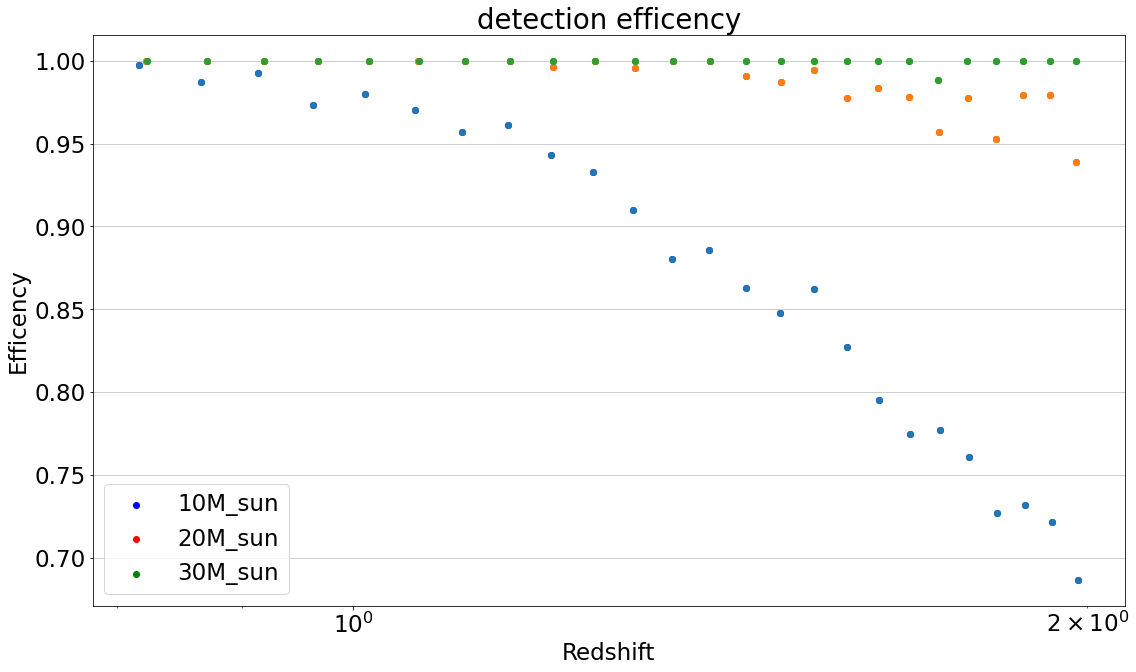

In [68]:
plt.rcParams.update({'font.size': 23})
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
m10, b10 = np.polyfit(midpoint10, percentage10, 1)
m20, b20 = np.polyfit(midpoint20, percentage20, 1)
#m30, b30 = np.polyfit(midpoint30, percentage30, 1)


ax.errorbar(midpoint10, percentage10, yerr=0, fmt="o")
#ax.plot(midpoint10[3:], percentage10[3:], 'yo', midpoint10[3:], m10*midpoint10[3:]+b10, '--b')
ax.scatter(midpoint10,percentage10,label='10M_sun',color='b')

ax.errorbar(midpoint20, percentage20, yerr=0, fmt="o")
#ax.plot(midpoint20[3:], percentage20[3:], 'yo', midpoint20[3:], m20*midpoint20[3:]+b20, '--y')
ax.scatter(midpoint20,percentage20,label='20M_sun',color='r')

ax.errorbar(midpoint30, percentage30, yerr=0, fmt="o")
#ax.plot(midpoint30[3:], percentage30[3:], 'yo', midpoint30[3:], m30*midpoint30[3:]+b10, '--r')
ax.scatter(midpoint30,percentage30,label='30M_sun',color='g')

plt.grid(axis='y', alpha=0.75)
plt.legend()
#plt.grid(axis='x', alpha=0.75)
plt.xlabel('Redshift')
plt.ylabel('Efficency')
plt.title('detection efficency')
plt.xscale('log')

In [62]:
#------------read the catalogue-------------------------------------
ds_x=np.asarray(mydata['DS_x'])
ds_y=np.asarray(mydata['DS_y'])
ds_z=np.asarray(mydata['DS_z'])
m1=np.asarray(mydata['M1'])
m2=np.asarray(mydata['M2'])
cos_inc=np.asarray(mydata['cos_orbital_incl'])
inclin=np.arccos(cos_inc)
psi=np.asarray(mydata['psi'])
zz=np.asarray(mydata['DS_redshift'])

In [63]:
theta=np.zeros(mydata.shape[0])
phi=np.zeros(mydata.shape[0])
com_distance=np.zeros(mydata.shape[0])
#SNR=np.zeros(EVA.shape[0])
for i in range(mydata.shape[0]):
    phi[i]=phi_from_cart(ds_x[i],ds_y[i])
    theta[i]=theta_from_cart(ds_x[i],ds_y[i],ds_z[i])
    com_distance[i]=np.sqrt(ds_x[i]**2+ds_y[i]**2+ds_z[i]**2)
cos_theta=np.random.uniform(-1,1,mydata.shape[0])#np.cos(theta)
phi=np.random.uniform(0,2*np.pi,mydata.shape[0])

In [64]:
print('I am doing the best I can, please wait...')
start_time = time.time()
with Pool(40) as p:
    mynewsnr=p.map(Multi_SNR_plus, range(mydata.shape[0]))
print("--- %s seconds ---" % (time.time() - start_time))

I am doing the best I can, please wait...


<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

--- 15.595229625701904 seconds ---


In [65]:
mydata.drop('SNR', inplace=True, axis=1)
mydata.insert(loc=14, column='SNR', value=mynewsnr)

/usr/lib/python3/dist-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
mydata.head()

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR,count
28,1473.370544,380.277651,2479.333496,0.808604,1473.370544,380.277651,2479.333496,0.808604,0.081533,6.641128,3.223255,0.485348,5.727144,b'IMRPhenomD',11.634105,1
72,592.358854,1725.526178,2265.015559,0.808363,592.358854,1725.526178,2265.015559,0.808363,-0.659711,6.682928,3.125461,0.467678,0.854460,b'IMRPhenomD',26.280981,1
77,867.047301,2537.836331,1096.379431,0.804409,867.047301,2537.836331,1096.379431,0.804409,-0.993184,7.105248,2.903938,0.408703,4.278400,b'IMRPhenomD',29.478191,1
115,539.991464,1683.082330,2322.028954,0.811904,539.991464,1683.082330,2322.028954,0.811904,0.660126,6.980936,2.778118,0.397958,1.134512,b'IMRPhenomD',29.005676,1
166,463.535184,341.658635,2868.854033,0.814716,464.456642,342.540150,2866.198364,0.813869,0.534297,8.621414,1.359953,0.157741,0.017572,b'IMRPhenomD',10.681971,1


In [ ]:
mynewsnr[0]

In [ ]:
print(cosmoglob.comoving_distance(zref).value*(1+zref))

In [101]:
zref=0.001
m1=7
m2=7
zds=0.2
lum_dist=cosmo15.comoving_distance(zds).value*(1+zds)
disr_mart=4.451350096358855
fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1+m2)*astro_const.M_sun.value)
df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
#FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
#                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
#                           distance=lum_distance[i],
#                           spin1z=0,spin2z=0,  
#                           delta_f=1.0/500,f_lower=0.5,f_final=0)
FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=lum_dist,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

In [102]:
mart_freq=np.loadtxt('freqtest.txt')
mart_wave=np.loadtxt('waveform.txt').view(complex)

In [103]:
falsecross=np.zeros(len(freq))
falsecross=falsecross.astype(int)
start_time = time.time()
hp_interpol=interpolate.interp1d(freq,abs(FDwfp*((1+zds)**2)),fill_value="extrapolate")
hc_interpol=interpolate.interp1d(freq,abs(falsecross),fill_value="extrapolate")
cos_theta=0
phi=0
psi=0
SNR=ET_SNR_Evaluation(cos_theta,phi,psi,hp_interpol,hc_interpol)
end_time= time.time()
print("--- %s seconds ---" % ((time.time() - start_time)))
print(SNR)

--- 0.11249518394470215 seconds ---
141.67926871024292


<ipython-input-4-14f25aa611d6>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]


In [72]:
 def snrfunc(zz, zz0, ff0, waveform0, lum_dist, det_noises):
        """
        This function returns the signal-to-noise ratio for an event.

        :param zz: the redshift of the event.
        :param zz0: a reference redshift.
        :param ff0: the frequency of the gravitational wave emitted by the merger.
        :param waveform0: the waveform (i.e. the GW strain) for the event.
        :param lum_dist: the luminosity distance to the event.
        :param source_extinctions: the source extinctions
        :param det_noises: the total power spectral density for the telescope.
        """
        #det_noises_sq_arr = np.array([det_noises[kk](ff) for kk in range(len(det_noises))])
        ff     = ff0#/(1+zz)
        ref_dL = disr_mart#cosmoglob.comoving_distance(zref).value*(1+zref)#lum_dist(zz0)
        new_dL = cosmoglob.comoving_distance(zz).value*(1+zz)#lum_dist(zz)
        #scaled_waveform = interpolate.interp1d(ff,waveform0*ref_dL/new_dL*(1+zz)**2,kind='cubic',bounds_error=False,fill_value=(0,0))
        scaled_waveform = interpolate.interp1d(ff,((1+zz)**2)*waveform0*ref_dL/new_dL,kind='cubic',bounds_error=False,fill_value=(0,0))
        integ = lambda x: 4*(np.square(np.real(scaled_waveform(x)))+np.square(np.imag(scaled_waveform(x))))/(3*det_noises(x)**2)
        #integ = lambda x: 4*(np.square(abs(scaled_waveform(x))))/(det_noises(x)**2)
        #snrsq_vec = []
        #for arm,noise in enumerate(det_noises):
        #    snrsq_vec.append(4 * np.trapz(self.snr_integrand(zz, zz0, ff0, waveform0, lum_dist, noise), ff))

        integrand = integ(ff)
        snr =  np.trapz(integrand, ff)
        #snr = quad(integ, min(ff), max(ff))[0]

        return snr#np.array(snrsq_vec)


In [73]:
mart_SNR=np.sqrt(snrfunc(zds, zref, freq, mart_wave, disr_mart, ET_sn))

In [74]:
print(mart_SNR)

154.09970912798275


In [75]:
100*(abs(SNR-mart_SNR))/SNR

8.766589869363061

In [76]:
m1=7
m2=7
lum_dist=cosmoglob.comoving_distance(zref).value*(1+zref)
disr_mart=4.451350096358855
fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1+m2)*astro_const.M_sun.value)
df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
#FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
#                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
#                           distance=lum_distance[i],
#                           spin1z=0,spin2z=0,  
#                           delta_f=1.0/500,f_lower=0.5,f_final=0)
FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=1,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp00 = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc00 = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=100,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp01 = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc01 = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=200,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp02 = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc02 = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]


<ipython-input-81-ee4df53311f2>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(freq,hp01(freq)/hp00(freq),label='h(100)/h(1)')
<ipython-input-81-ee4df53311f2>:11: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(freq,hp02(freq)/hp00(freq),label='h(200)/h(1)')


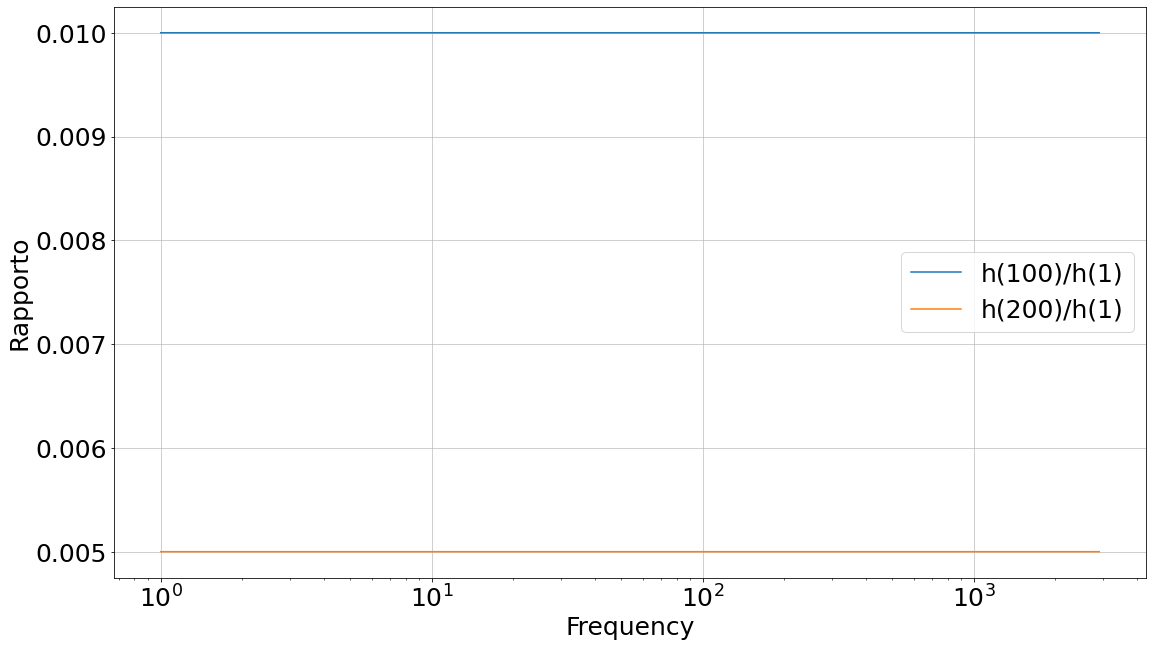

In [81]:
hp00=interpolate.interp1d(freq,abs(FDwfp00),fill_value="extrapolate")
hp01=interpolate.interp1d(freq,abs(FDwfp01),fill_value="extrapolate")
hp02=interpolate.interp1d(freq,abs(FDwfp02),fill_value="extrapolate")
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('Rapporto')
ax.plot(freq,hp01(freq)/hp00(freq),label='h(100)/h(1)')
ax.plot(freq,hp02(freq)/hp00(freq),label='h(200)/h(1)')
#ax.plot(freq,hp02(freq)/hp01(freq),label='h(200)/h(100)')
#ax.plot(freq,hp(freq),label='hand made')
#ax.plot(freq,hp_abs(freq)**2,label='abs')

#plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()